In [1]:
import torch
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [2]:
url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res = requests.get(url)
full_text = res.text
words = full_text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    xs, ys = [], []
    
    for word in words:
        ctx = [0] * block_size
        for char in word + ".":
            ix = stoi[char]
            xs.append(ctx)
            ys.append(ix)
            ctx = ctx[1:] + [ix]
            
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

for i in range(5):
    example_x, example_y = Xtr[i], Ytr[i]
    output = ""
    for j in range(len(example_x)):
        output += itos[example_x[j].item()]
    print("Context:", output)
    print("Expected:", itos[example_y.item()])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Context: ...
Expected: y
Context: ..y
Expected: u
Context: .yu
Expected: h
Context: yuh
Expected: e
Context: uhe
Expected: n


std must be 1/sqrt(fan_in)

In [56]:
n_embd = 10
n_hidden = 200

C = torch.randn(vocab_size, n_embd) 
w1 = torch.randn(n_embd * block_size, n_hidden)  *0.0#*(5/3) / (n_embd * block_size)**0.5 
#b1 = torch.randn(n_hidden) * 0.01
w2 = torch.randn(n_hidden, vocab_size) *0.0#/ (n_hidden)**0.5
b2 = torch.randn(vocab_size) * 0.0# * 0

bngain = torch.ones(1, n_hidden) * 1.0
bnbias = torch.zeros(1, n_hidden) * 0.0

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, w1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [57]:
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb, yb = Xtr[ix], Ytr[ix]

    emb = C[xb]

    embcat = emb.view(emb.shape[0], -1)

    # should be roughly gaussian
    hpreact = embcat @ w1 #+ b1

    # batchnorm layer
    # ------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------

    h = torch.tanh(hpreact)

    logits = h @ w2 + b2

    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    
    if step % 10000 == 0:
        print(f"step: {step} | loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())


step: 0 | loss: 3.2958
step: 10000 | loss: 2.7858
step: 20000 | loss: 2.8332
step: 30000 | loss: 2.7500
step: 40000 | loss: 2.6384
step: 50000 | loss: 2.8172
step: 60000 | loss: 2.6830
step: 70000 | loss: 2.4620
step: 80000 | loss: 3.1721
step: 90000 | loss: 2.7890
step: 100000 | loss: 2.8695
step: 110000 | loss: 2.6122
step: 120000 | loss: 2.9535
step: 130000 | loss: 2.8840
step: 140000 | loss: 2.5798
step: 150000 | loss: 2.7023
step: 160000 | loss: 2.8170
step: 170000 | loss: 2.8192
step: 180000 | loss: 2.8922
step: 190000 | loss: 2.6860


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 6400.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

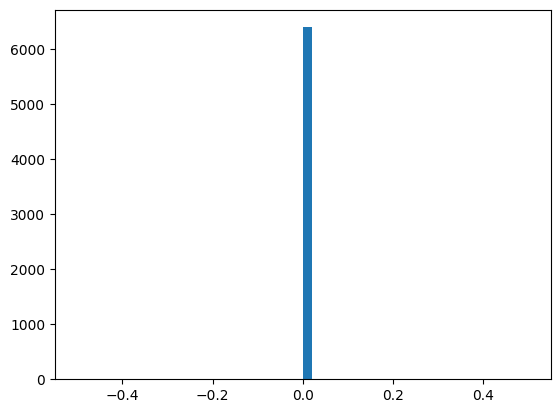

In [58]:
plt.hist(h.view(-1).tolist(), 50)

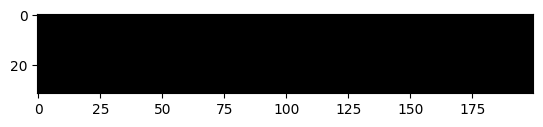

In [59]:
mask = h.abs() > 0.9
plt.imshow(mask, cmap="gray", interpolation='nearest')

In [60]:
logits[0]

tensor([ 1.9219,  1.9778, -0.5798, -0.2792,  0.1710,  1.4703, -1.6202, -0.8627,
         0.5103,  1.3490, -0.4732,  0.0724,  1.0967,  0.3329,  1.3682,  0.5650,
        -1.5044, -2.8705,  1.0094,  0.5442,  0.1744, -0.4089, -0.6260, -1.5630,
        -1.9076,  0.7636, -0.6318], grad_fn=<SelectBackward0>)

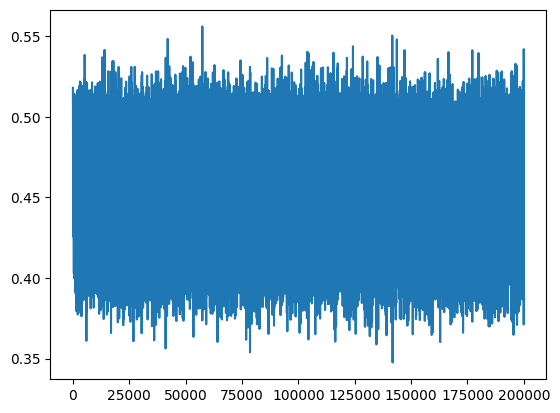

In [61]:
plt.plot(lossi)

In [62]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = hpreact.tanh()
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.8226523399353027
val 2.8211545944213867


In [63]:
for i in range(20):
    name = ""
    ctx = [0] * block_size
    for x in range(30):
        ins = torch.tensor(ctx)
        emb = C[ins]
        embcat = emb.view(-1)
        hpreact = embcat @ w1 
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = hpreact.tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=-1)
        selected = torch.multinomial(probs, num_samples=1).item()
        ctx = ctx[1:] + [selected]
        name += itos[selected]
        if itos[selected] == ".":
            break
    print(name)

rn.
alerebyecsaczieiireihedoa.
dax.
saenernhemmsn.
tiainek.
gr.
aucasiecohda.
mr.
jlde.
atqk.
mia.
.
inekaeuemnoseayatiyyiaceallo.
yeieealamnayidravde.
neahoiaaaoinikaar.
niry.
e.
.
riikr.
.


In [71]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]

class BatchNorm1d:
    def __init__(self, n_features, eps=1e-5, momentum=0.1):
        self.n_features = n_features
        self.eps = eps
        self.momentum = momentum

        self.training = True

        self.bngain = torch.ones(1, n_features)
        self.bnbias = torch.zeros(1, n_features)

        self.bnmean_running = torch.zeros(1, n_features)
        self.bnstd_running = torch.ones(1, n_features)
    def __call__(self, x):
        if self.training:
            bnmeani = x.mean(0, keepdim=True)
            bnstdi = x.std(0, keepdim=True)
        else:
            bnmeani = self.bnmean_running
            bnstdi = self.bnstd_running
        self.out = self.bngain * (x - bnmeani) / (bnstdi + self.eps) + self.bnbias
        if self.training:
            with torch.no_grad():
                self.bnmean_running = (1-self.momentum) * self.bnmean_running + bnmeani * self.momentum
                self.bnstd_running = (1-self.momentum) * self.bnstd_running + bnstdi * self.momentum
        return self.out
    def parameters(self):
        return [self.bngain, self.bnbias]
    
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
C = torch.randn(vocab_size, n_embd)
layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].bngain *= 0.0
    
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.0
            layer.bias * 0.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [79]:
[layer for layer in layers if isinstance(layer, Linear)][0].weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [73]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for step in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb = Xtr[ix]
    yb = Ytr[ix]
    
    emb = C[xb]
    x = emb.view(batch_size, -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    
    if step % 10000 == 0:
        print(f"step: {step} | loss: {loss.item():.4f}")

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # if step >= 1000:
    #     break

step: 0 | loss: 3.2958
step: 10000 | loss: 2.8642
step: 20000 | loss: 2.7419
step: 30000 | loss: 2.9423
step: 40000 | loss: 2.7468
step: 50000 | loss: 2.8723
step: 60000 | loss: 2.7529
step: 70000 | loss: 2.6945
step: 80000 | loss: 2.9515
step: 90000 | loss: 3.1872
step: 100000 | loss: 2.8983
step: 110000 | loss: 2.7657
step: 120000 | loss: 2.9109
step: 130000 | loss: 2.7843
step: 140000 | loss: 2.7751
step: 150000 | loss: 2.8058
step: 160000 | loss: 2.9916
step: 170000 | loss: 2.9699
step: 180000 | loss: 2.7554
step: 190000 | loss: 2.7885


layer 2 Tanh: mean 0.0000, std 0.0000, saturated: 0.00%
layer 5 Tanh: mean 0.0000, std 0.0000, saturated: 0.00%
layer 8 Tanh: mean 0.0000, std 0.0000, saturated: 0.00%
layer 11 Tanh: mean 0.0000, std 0.0000, saturated: 0.00%
layer 14 Tanh: mean 0.0000, std 0.0000, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

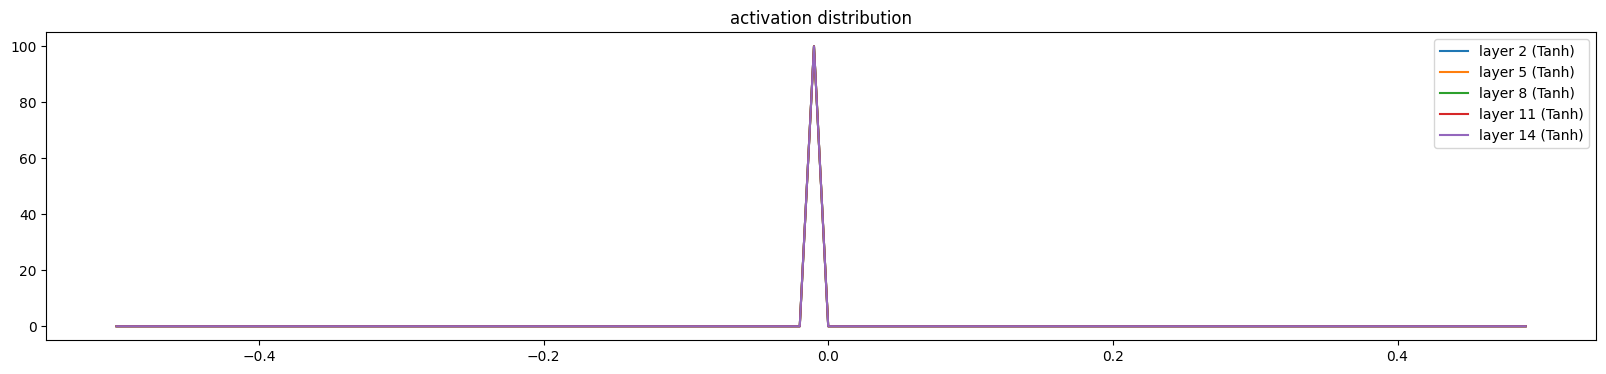

In [74]:
plt.figure(figsize=(20, 4))
legends = []
for i , layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean().item():.4f}, std {t.std().item():.4f}, saturated: {((t.abs() > 0.97).float().mean() * 100):.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 Tanh: mean 0.00000000, std 0.00000000
layer 5 Tanh: mean 0.00000000, std 0.00000000
layer 8 Tanh: mean 0.00000000, std 0.00000000
layer 11 Tanh: mean 0.00000000, std 0.00000000
layer 14 Tanh: mean 0.00000000, std 0.00000000


Text(0.5, 1.0, 'gradient distribution')

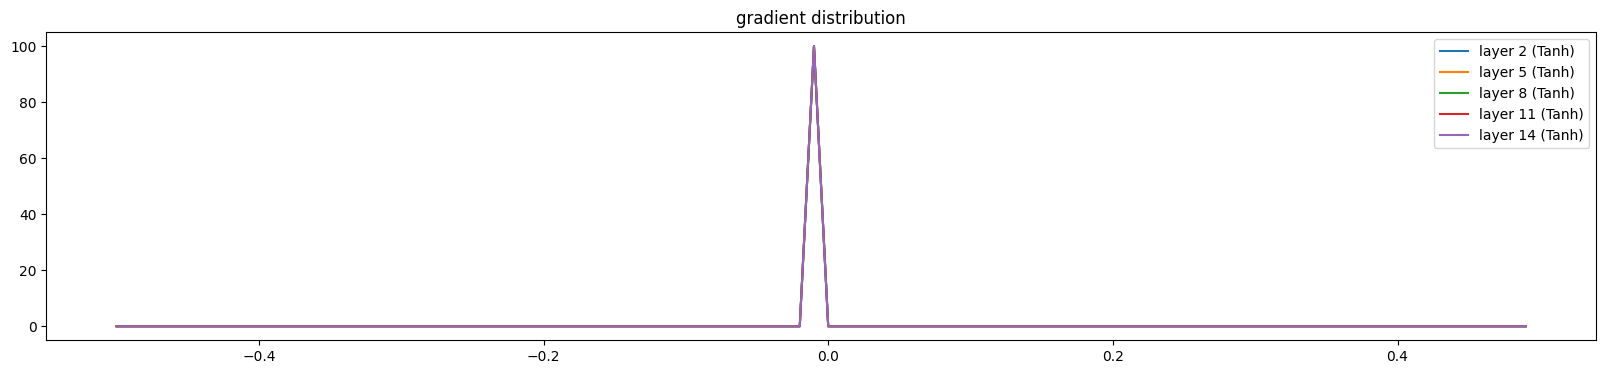

In [75]:
plt.figure(figsize=(20, 4))
legends = []
for i , layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean().item():.8f}, std {t.std().item():.8f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight (27, 10) | mean -0.06004960 | std 1.0631e+00 | grad:data ratio 0.0000e+00
weight (30, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 1.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (100, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 1.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (100, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 1.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (100, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 1.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (1, 100) | mean 0.00000000 | std 0.0000e+00 | grad:data ratio nan
weight (100, 100) | mean 0.00000000 

Text(0.5, 1.0, 'weights gradient distribution')

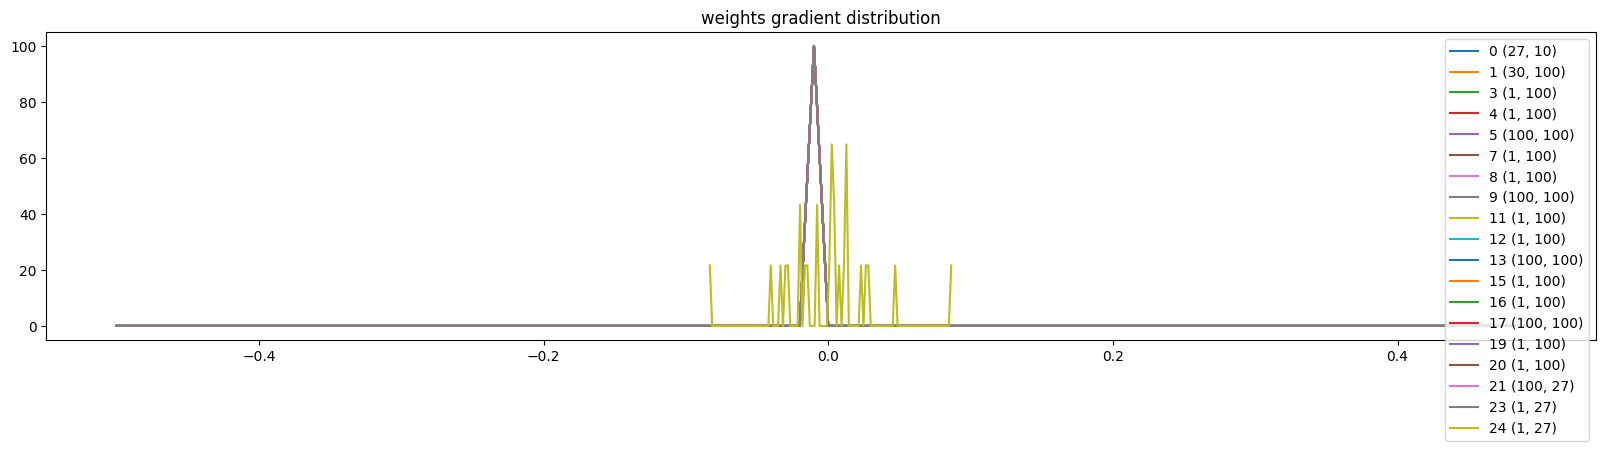

In [76]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)} | mean {p.mean().item():.8f} | std {p.std().item():.4e} | grad:data ratio {(t.std() / p.std()).item():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("weights gradient distribution")

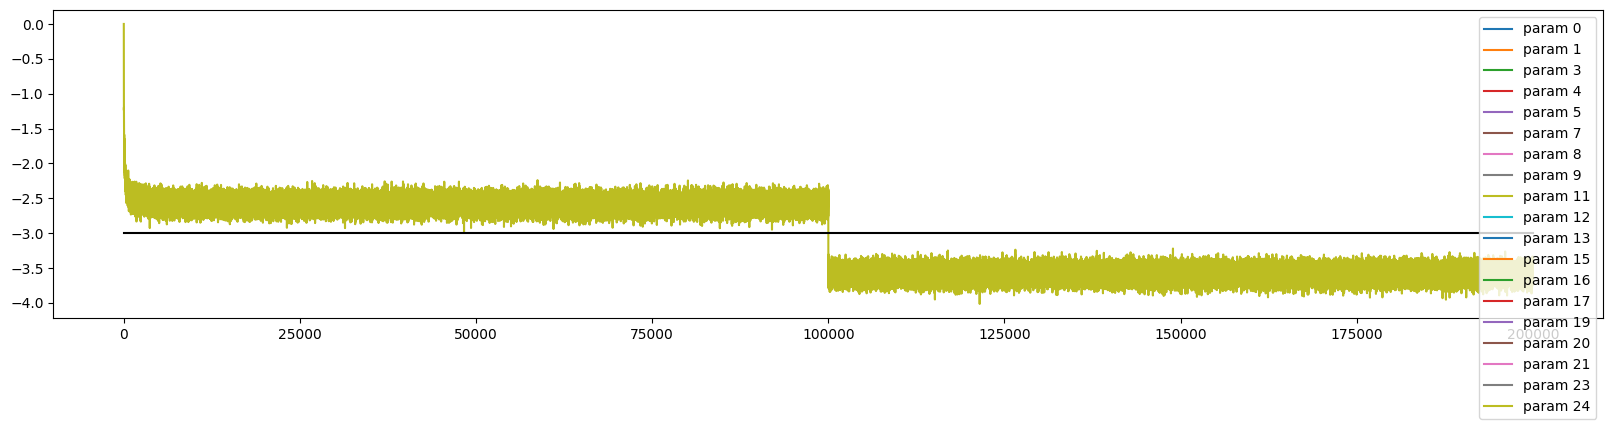

In [80]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [82]:
n_embd = 10
n_hidden = 100
C = torch.randn(vocab_size, n_embd)
w1 = torch.randn(block_size * n_embd, n_hidden) * (5/3) / (block_size * n_embd)**0.5
b1 = torch.randn(n_hidden) * 0.01
w2 = torch.randn(n_hidden, n_hidden) * (5/3) / n_hidden**0.5
b2 = torch.randn(n_hidden) * 0.01
w3 = torch.randn(n_hidden, vocab_size) / n_hidden**0.5
b3 = torch.randn(vocab_size) * 0.01

bngain = torch.ones(n_hidden)
bnbias = torch.zeros(n_hidden)

bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.ones(n_hidden)

params = [w1, b1, w2, b2, w3, b3, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [83]:
max_steps = 50000
batch_size = 32

for step in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb = Xtr[ix]
    yb = Ytr[ix]

    emb = C[xb]
    embcat = emb.view(batch_size, -1)
    l1preact = embcat @ w1 + b1

    # batchnorm
    bnmeani = l1preact.mean(0, keepdim=True)
    bnstdi = l1preact.std(0, keepdim=True)

    l1preact = bngain * (l1preact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + bnmeani * 0.001
        bnstd_running = 0.999 * bnstd_running + bnstdi * 0.001
    
    l1 = l1preact.tanh()
    l2preact = l1 @ w2 + b2
    l2 = l2preact.tanh()
    logits = l2 @ w3 + b3

    loss = F.cross_entropy(logits, yb)

    for p in params:
        p.grad = None
    
    loss.backward()

    lr = 0.1 if step < 20000 else 0.01
    for p in params:
        p.data -= p.grad * lr
    
    if step % 10000 == 0:
        print(f"step: {step} | loss: {loss.item():.4f}")

step: 0 | loss: 3.6403
step: 10000 | loss: 2.0171
step: 20000 | loss: 2.2494
step: 30000 | loss: 2.2996
step: 40000 | loss: 2.1463


In [85]:
test = Xtr[0]
emb = C[test]
embcat = emb.view(-1)
l1preact = embcat @ w1 + b1

l1preact = bngain * (l1preact - bnmean_running) / bnstd_running + bnbias
l1 = l1preact.tanh()
l2preact = l1 @ w2 + b2
l2 = l2preact.tanh()
logits = l2 @ w2 + b2
print(logits)

tensor([[ 2.3986,  3.9571, -0.1282,  0.4731, -1.8648,  0.1304, -0.0352,  2.9244,
          2.4008, -0.4670,  1.4817, -0.4749, -1.7956,  2.1025, -0.2483,  0.7785,
          0.9006,  4.2223,  2.5342,  1.2743,  1.1097,  0.2664,  3.0832, -0.0298,
         -4.4350, -0.7171, -2.4611,  0.5700,  2.8803, -0.5383, -2.9577,  0.0552,
          3.4130,  0.9595, -0.3749,  3.1501, -0.2948,  0.2099,  3.3457,  3.0371,
         -1.3685,  1.2249, -4.4252, -0.4416,  0.3585,  0.8754,  1.2427,  0.9911,
         -1.6989, -3.2384,  1.8041, -1.0145, -2.1745, -2.9043,  0.3838, -2.8251,
          1.3232, -1.1573, -1.6891, -3.4103,  0.7828,  0.2214,  3.7071, -1.0750,
         -4.7055,  1.0244,  1.8805, -2.4609,  1.7057, -1.7897, -0.6650, -1.7137,
          0.0210, -1.8108, -3.2762, -0.2934, -3.9453,  2.7246,  0.2887, -2.1040,
         -2.6810, -0.1514, -1.8028,  2.1630, -0.1104,  2.8864,  0.1246, -0.0332,
          2.4159,  0.4426, -3.4396, -0.1731,  0.5920, -4.1335, -0.4476, -2.1005,
          2.0534, -2.2736, -

In [88]:
# batchnorm folding

test = Xtr[0]

w1fold = bngain * (w1/bnstd_running)
b1fold = bngain * ((b1-bnmean_running)/bnstd_running) + bnbias
emb = C[test]
embcat = emb.view(-1)
l1preact = embcat @ w1fold + b1fold

#l1preact = bngain * (l1preact - bnmean_running) / bnstd_running + bnbias
l1 = l1preact.tanh()
l2preact = l1 @ w2 + b2
l2 = l2preact.tanh()
logits = l2 @ w2 + b2
print(logits)

tensor([[ 2.3986,  3.9571, -0.1282,  0.4731, -1.8648,  0.1304, -0.0352,  2.9244,
          2.4008, -0.4670,  1.4817, -0.4749, -1.7956,  2.1025, -0.2483,  0.7785,
          0.9006,  4.2223,  2.5342,  1.2743,  1.1097,  0.2664,  3.0833, -0.0298,
         -4.4350, -0.7171, -2.4611,  0.5700,  2.8803, -0.5383, -2.9577,  0.0552,
          3.4130,  0.9595, -0.3749,  3.1501, -0.2948,  0.2099,  3.3457,  3.0371,
         -1.3685,  1.2249, -4.4252, -0.4416,  0.3585,  0.8754,  1.2427,  0.9911,
         -1.6989, -3.2384,  1.8041, -1.0145, -2.1745, -2.9043,  0.3838, -2.8251,
          1.3232, -1.1573, -1.6891, -3.4103,  0.7828,  0.2214,  3.7071, -1.0750,
         -4.7055,  1.0244,  1.8805, -2.4609,  1.7057, -1.7897, -0.6650, -1.7137,
          0.0210, -1.8108, -3.2762, -0.2934, -3.9453,  2.7246,  0.2887, -2.1040,
         -2.6810, -0.1514, -1.8028,  2.1630, -0.1104,  2.8864,  0.1246, -0.0332,
          2.4159,  0.4426, -3.4396, -0.1731,  0.5920, -4.1335, -0.4476, -2.1005,
          2.0534, -2.2736, -